We have worked on portfolio optimization based on the Markowitz mean-variance optimization framework to maximize the expected return for the given level of risk. Using cvxopt package, we defined two functions optimal portfolio risk and the other as maximum ROI based out of risk associated with the asset.

[*********************100%***********************]  5 of 5 completed
     pcost       dcost       gap    pres   dres
 0: -1.8380e-06 -1.0000e+00  1e+00  2e-16  3e+00
 1: -1.8380e-06 -1.0005e-02  1e-02  1e-16  3e-02
 2: -1.8386e-06 -1.0510e-04  1e-04  7e-17  3e-04
 3: -1.8931e-06 -6.0935e-06  4e-06  7e-17  1e-05
 4: -4.8965e-06 -6.3656e-06  1e-06  2e-16  1e-06
 5: -4.9767e-06 -4.9989e-06  2e-08  2e-16  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.8378e-06 -1.0000e+00  1e+00  3e-16  3e+00
 1: -1.8378e-06 -1.0005e-02  1e-02  2e-16  3e-02
 2: -1.8383e-06 -1.0510e-04  1e-04  2e-16  3e-04
 3: -1.8929e-06 -6.0930e-06  4e-06  2e-16  1e-05
 4: -4.8945e-06 -6.3633e-06  1e-06  2e-16  1e-06
 5: -4.9749e-06 -4.9970e-06  2e-08  1e-16  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.8376e-06 -1.0000e+00  1e+00  0e+00  3e+00
 1: -1.8376e-06 -1.0005e-02  1e-02  1e-16  3e-02
 2: -1.8381e-06 -1.0510e-04  1e-04  2e-16  3e-04
 3: 

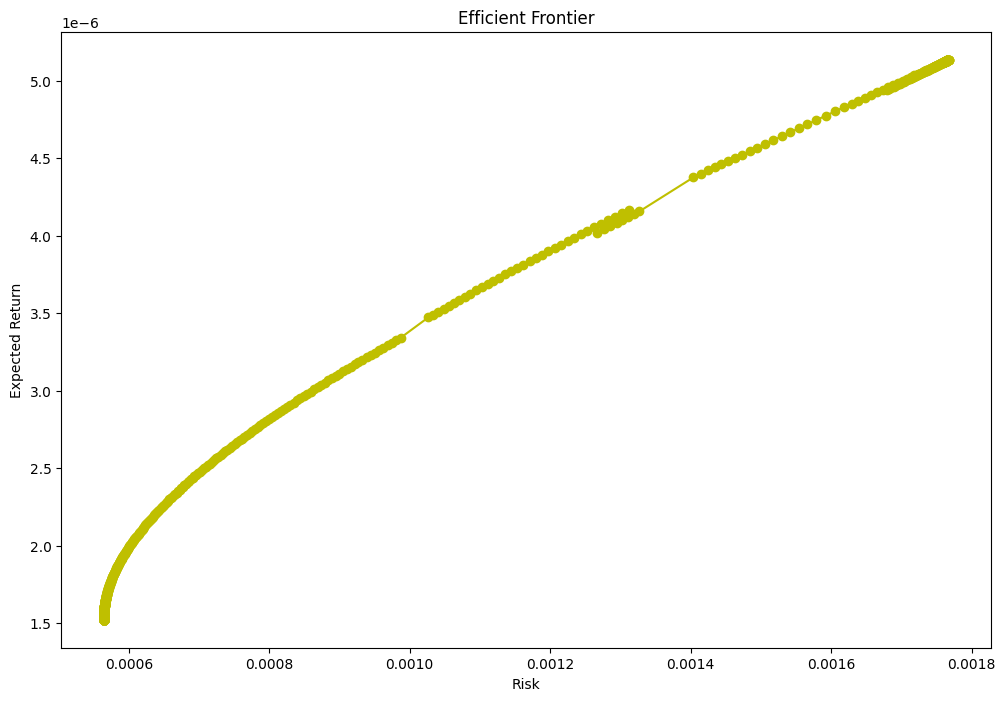

Maximum Return for the given risk (15): 5.095672061142181e-06


In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt  # type: ignore
from cvxopt import blas, solvers  # type: ignore

# Define the list of stocks
tickers = ['NVDA', 'SIRI', 'AAPL', 'BAC', 'CSCO']

# Download historical adjusted close prices for the specified tickers and date range
data = yf.download(tickers=tickers, start='2010-01-01', end='2023-01-01')['Adj Close']

# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Calculate mean and covariance of the daily returns
mu = daily_returns.mean().values
sigma = daily_returns.std().values
cov_matrix = daily_returns.cov().values

# Simulate future prices using GBM based on the Black-Scholes model
def simulate_gbm(S0, mu, sigma, T, dt, M):
    N = int(T / dt)
    S = np.zeros((N+1, M))
    S[0] = S0
    
    for t in range(1, N+1):
        Z = np.random.standard_normal(M)
        S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    return S

# Parameters
S0 = data.iloc[-1].values  # Initial stock prices (last available prices)
T = 1.0  # Time period in years
dt = 1/252  # Time step (daily)
M = 1000  # Number of simulations

# Simulate GBM for each stock
simulated_prices = np.zeros((len(tickers), int(T/dt) + 1, M))
for i, (mu_i, sigma_i) in enumerate(zip(mu, sigma)):
    simulated_prices[i] = simulate_gbm(S0[i], mu_i, sigma_i, T, dt, M)

# Calculate expected returns and covariance matrix for the simulated prices
simulated_returns = np.log(simulated_prices[:, 1:] / simulated_prices[:, :-1])
expected_returns = simulated_returns.mean(axis=(1, 2))
cov_matrix = np.cov(simulated_returns.reshape(len(tickers), -1))

# Portfolio optimization
def optimal_portfolio(returns, cov_matrix):
    n = len(returns)
    returns = np.asmatrix(returns).reshape(-1, 1)  # Ensure returns is a column vector

    N = 1000
    mus = [10**(5.0 * t / N - 1.0) for t in range(N)]

    S = opt.matrix(cov_matrix)
    pbar = opt.matrix(returns)

    G = opt.matrix(-np.eye(n))
    h = opt.matrix(np.zeros(n))
    A = opt.matrix(np.ones((1, n)))
    b = opt.matrix(np.ones(1))

    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x'] for mu in mus]
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x.T, S * x)) for x in portfolios]

    return returns, risks, portfolios

def max_return_for_given_risk(returns, cov_matrix, target_risk):
    n = len(returns)
    returns = np.asmatrix(returns).reshape(-1, 1)  # Ensure returns is a column vector

    S = opt.matrix(cov_matrix)
    pbar = opt.matrix(returns)

    G = opt.matrix(np.vstack((np.zeros((1, n)), -np.eye(n))))
    h = opt.matrix(np.vstack((np.array([target_risk]), np.zeros((n, 1)))))
    A = opt.matrix(np.ones((1, n)))
    b = opt.matrix(np.ones(1))

    risk_free_portfolio = solvers.qp(S, -pbar, G, h, A, b)['x']
    return blas.dot(pbar, risk_free_portfolio), np.sqrt(blas.dot(risk_free_portfolio.T, S * risk_free_portfolio))

# Optimize Portfolio
optimized_returns, risks, portfolios = optimal_portfolio(expected_returns, cov_matrix)

# Set target risk level
target_risk = 15

# Find the maximum return for the given risk
max_return, actual_risk = max_return_for_given_risk(expected_returns, cov_matrix, target_risk)

# Plotting the efficient frontier
plt.figure(figsize=(12, 8))
plt.plot(risks, optimized_returns, 'y-o')
plt.xlabel('Risk')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.scatter(actual_risk, max_return, color='red')  # Highlight the max return for the given risk
plt.show()

print(f"Maximum Return for the given risk ({target_risk}): {max_return}")